In [1]:
import subprocess
import tqdm
from pathlib import Path
import torch
import torch.nn as nn
import os
import numpy as np
from omegaconf import OmegaConf

import hydra
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig

import sys
sys.path.append('../')
from src.utils.protein import from_pdb_file, to_pdb
from src.models.TorsionalDiffusion import TDiffusionModule
from src.datamodules.components.helper import *
from src.models.components import get_atom14_coords
from src.utils.protein_analysis import ProteinAnalysis

from pyrosetta import init, pose_from_pdb, get_fa_scorefxn, Pose, standard_packer_task
import pickle
import glob

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
initialize(version_base="1.3", config_path="../configs")
# initialize(config_path="configs")
cfg = compose(config_name="eval_diffusion.yaml", return_hydra_config=True)
HydraConfig().cfg = cfg
OmegaConf.resolve(cfg)

In [3]:
molprobity_clash_loc = '/home/zhangjk/MolProbity/build/bin/molprobity.clashscore'
tmp_dir = '/home/zhangjk/test/PackPPI/temp1'
pdb_file = '/home/zhangjk/test/PackPPI/data/casp15_set/targets/T1152_lig.pdb'
output_pkl = '/home/zhangjk/test/PackPPI/decoys_landscape.pkl'
output_pdf = '/home/zhangjk/test/PackPPI/Figure3B1.pdf'
decoys = 128
device = 'cuda:0' #"cpu"

protein_analysis = ProteinAnalysis(molprobity_clash_loc, tmp_dir)

In [4]:
model = TDiffusionModule.load_from_checkpoint(
    # allow one to evaluate with an older model using custom hyperparameters
    checkpoint_path=cfg.ckpt_path,
    map_location=device,
    strict=False,
    encoder_cfg=hydra.utils.instantiate(cfg.model.encoder_cfg),
    model_cfg=hydra.utils.instantiate(cfg.model.model_cfg),
    sample_cfg=hydra.utils.instantiate(cfg.model.sample_cfg)
)

model = model.to(device)
model.eval()


TDiffusionModule(
  (encoder): ProteinEncoder(
    (timestep_emb_func): SinusoidalEmbedding()
    (node_embedding): Linear(in_features=51, out_features=128, bias=True)
    (norm_nodes): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (edge_embedding): Linear(in_features=468, out_features=128, bias=True)
    (norm_edges): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (embeddings): PositionalEncodings()
  )
  (mpnn): MpnnNet(
    (mpnn_layers): ModuleList(
      (0-2): 3 x InvariantPointMessagePassing(
        (points_fn_node): Linear(in_features=128, out_features=24, bias=True)
        (points_fn_edge): Linear(in_features=128, out_features=24, bias=True)
        (node_message_fn): MLP(
          (W_in): Linear(in_features=456, out_features=128, bias=True)
          (W_inter): ModuleList(
            (0): Linear(in_features=128, out_features=128, bias=True)
          )
          (W_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (edge_me

In [5]:
def analyze_proteins(pdb_file, output_pkl, decoys, model, device):
    """
    Analyze protein structures from PDB files and save results to a pickle file.

    Parameters:
    pdb_files (list): List of paths to PDB files.
    output_pkl (str): Output file path for saving results.
    decoys (int): Number of decoys to generate for each protein.
    model: Model used for sampling.
    device: Device for computation (CPU or GPU).
    """
    init('-mute all '
         '-ex1 -ex2 -ex3 -ex4 '
         '-ignore_unrecognized_res '
         '-ignore_zero_occupancy false '
         '-load_PDB_components false ' 
         '-relax:default_repeats 2 '
         '-no_fconfig ')
    
    scorefxn = get_fa_scorefxn()
    data = {}

    protein = vars(from_pdb_file(Path(pdb_file), mse_to_met=True))
    batch = protein_analysis.get_prot(pdb_file).to(device)
    
    sample_metrics = {'reu': [], 'rmsd': [], 'clash': []}
    resample_metrics = {'reu': [], 'rmsd': [], 'clash': []}

    for num in tqdm.trange(decoys):
        try:
            SC_D_sample, SC_D_resample_list, _ = model.sampling(batch, use_proximal=True, return_list=True)
        except RuntimeError:
            torch.cuda.empty_cache()
            break
        
        # Analyze the sampled structure
        for sample_type, SC_D in zip(['sample', 'resample'], [SC_D_sample, SC_D_resample_list[-1]]):
            predict_xyz = get_atom14_coords(batch.X, batch.residue_type, batch.BB_D, SC_D)
            protein['atom_positions'] = predict_xyz.cpu().squeeze().numpy()
            temp_protein = to_pdb(protein)
            
            with open(protein_analysis.tmp_pdb, 'w') as temp_file:
                temp_file.writelines(temp_protein)

            try:
                pose = pose_from_pdb(protein_analysis.tmp_pdb)
                score = scorefxn(pose)
                metric = protein_analysis.get_metric(pdb_file, protein_analysis.tmp_pdb)

                if sample_type == 'sample':
                    sample_metrics['reu'].append(score)
                    sample_metrics['rmsd'].append(metric['atom_rmsd'])
                    sample_metrics['clash'].append(metric['clashscore'])
                else:
                    resample_metrics['reu'].append(score)
                    resample_metrics['rmsd'].append(metric['atom_rmsd'])
                    resample_metrics['clash'].append(metric['clashscore'])

            except RuntimeError:
                break

    # Store results in the data dictionary
    data[f'sample_packppi_reu'] = sample_metrics['reu']
    data[f'sample_packppi_Prox_reu'] = resample_metrics['reu']
    data[f'sample_packppi_rmsd'] = sample_metrics['rmsd']
    data[f'sample_packppi_Prox_rmsd'] = resample_metrics['rmsd']
    data[f'sample_packppi_clash'] = sample_metrics['clash']
    data[f'sample_packppi_Prox_clash'] = resample_metrics['clash']

    # Save the results to a pickle file
    with open(output_pkl, 'wb') as f:
        pickle.dump(data, f)

In [6]:
analyze_proteins(pdb_file, output_pkl, decoys, model, device)

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.ubuntu 2024.19+release.a34b73c40fe9c61558d566d6a63f803cfb15a4fc 2024-05-02T16:22:03] retrieved from: http://www.pyrosetta.org


100%|█████████████████████████████████████████████████████████████████| 128/128 [17:44<00:00,  8.32s/it]


In [7]:
decoys

128

In [8]:
with open(output_pkl, 'rb') as f:
    data = pickle.load(f)

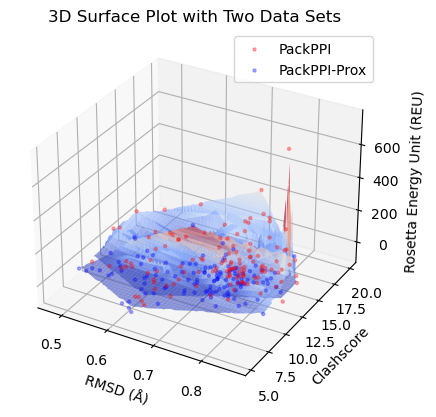

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import pandas as pd

reu = data['sample_packppi_reu']
rmsd = data['sample_packppi_rmsd']
clash = data['sample_packppi_clash']
reu_prox = data['sample_packppi_Prox_reu']
rmsd_prox = data['sample_packppi_Prox_rmsd']
clash_prox = data['sample_packppi_Prox_clash']

X1, Y1, Z1 = np.array(rmsd), np.array(clash), np.array(reu)
X2, Y2, Z2 = np.array(rmsd_prox), np.array(clash_prox), np.array(reu_prox)

x_min, x_max = min(min(X1), min(X2)), max(max(X1), max(X2))
y_min, y_max = min(min(Y1), min(Y2)), max(max(Y1), max(Y2))
x_lin = np.linspace(x_min, x_max, 100)
y_lin = np.linspace(y_min, y_max, 100)
X_grid, Y_grid = np.meshgrid(x_lin, y_lin)

Z1_grid = griddata((X1, Y1), Z1, (X_grid, Y_grid), method='linear')
Z2_grid = griddata((X2, Y2), Z2, (X_grid, Y_grid), method='linear')

Z1_grid = np.clip(Z1_grid, 0, None)
Z2_grid = np.clip(Z2_grid, 0, None)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf1 = ax.plot_surface(X_grid, Y_grid, Z1_grid, cmap='coolwarm', alpha=0.6)
surf2 = ax.plot_surface(X_grid, Y_grid, Z2_grid, cmap='coolwarm', alpha=0.6)

ax.scatter(X1, Y1, Z1, color='r', alpha=0.3, label='PackPPI', s=5)
ax.scatter(X2, Y2, Z2, color='b', alpha=0.3, label='PackPPI-Prox', s=5)
ax.set_facecolor('white')

ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('Clashscore')
ax.set_zlabel('Rosetta Energy Unit (REU)')
ax.set_title('3D Surface Plot with Two Data Sets')

ax.legend()
plt.savefig('3d_surface_plot.pdf', format='pdf')
plt.show()



In [10]:
data1 = pd.DataFrame({'RMSD': X1, 'Clashscore': Y1, 'REU': Z1, 'Label': 'PackPPI'})
data2 = pd.DataFrame({'RMSD': X2, 'Clashscore': Y2, 'REU': Z2, 'Label': 'PackPPI-Prox'})

combined_data = pd.concat([data1, data2], ignore_index=True)

combined_data.to_csv('combined_data.csv', index=False)